In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [12]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [13]:
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [14]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


In [15]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [16]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *


In [19]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())                                   ####Stable learning
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
model=my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 128)      

In [26]:
from tensorflow.keras import backend as K

path_model='model_filter.h5' # save model at this location after each epoch
K.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model

K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model

h = model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/20


KeyboardInterrupt: 

In [27]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [18]:
model.save("Saved_Model")

INFO:tensorflow:Assets written to: Saved_Model\assets


In [28]:
model = tf.keras.models.load_model('Saved_Model')

In [23]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [24]:
y_pred = model.predict(X_test)
y_test.shape

(3589, 7)

In [22]:
print(y_pred)

[[3.87436536e-04 1.50258526e-08 1.80092483e-10 ... 6.75180311e-12
  1.03935582e-09 3.90028097e-02]
 [8.76883447e-01 2.10875805e-06 3.93490819e-03 ... 1.34766819e-02
  2.47879536e-04 1.05454154e-01]
 [3.26554268e-03 4.05022007e-07 6.93340421e-01 ... 8.49372223e-02
  2.18349457e-01 5.04845821e-06]
 ...
 [7.97621324e-04 9.22125822e-04 7.05876827e-01 ... 9.01037641e-03
  2.31331319e-06 2.49312088e-01]
 [1.69067264e-01 3.81597289e-04 2.70095770e-05 ... 7.27496626e-06
  7.00957433e-04 4.74065006e-01]
 [5.81683755e-01 1.71817007e-07 4.14044648e-01 ... 3.98347527e-03
  7.41943768e-06 1.28536221e-05]]


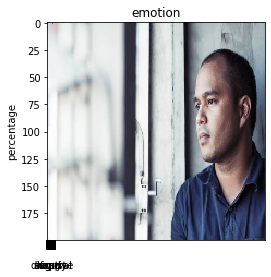

Expression Prediction: sad


In [23]:
from skimage import io
img = image.load_img('sad.jpg', color_mode = "grayscale", target_size=(48, 48))
show_img = image.load_img('sad.jpg',  target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m = 0.000000000000000000001
a = custom[0]
for i in range(0,len(a)):
    if a[i] > m:
        m = a[i]
        ind = i
        
print('Expression Prediction:',objects[ind])
        

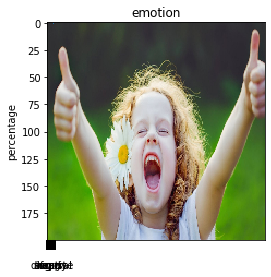

Expression Prediction: surprise


In [16]:
from skimage import io
img = image.load_img('sad1.jpg', color_mode = "grayscale", target_size=(48, 48))
show_img = image.load_img('sad1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m = 0.000000000000000000001
a = custom[0]
for i in range(0,len(a)):
    if a[i] > m:
        m = a[i]
        ind = i
        
print('Expression Prediction:',objects[ind])

In [24]:
from cv2 import *

In [25]:
def getExpr(file):
    from skimage import io
    img = tf.keras.preprocessing.image.load_img(file, color_mode = "grayscale", target_size=(48, 48))
    show_img = tf.keras.preprocessing.image.load_img(file, grayscale=False, target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(show_img)
    plt.show()

    m = 0.000000000000000000001
    a = custom[0]
    for i in range(0,len(a)):
        if a[i] > m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])

opencv_frame_10.png written!


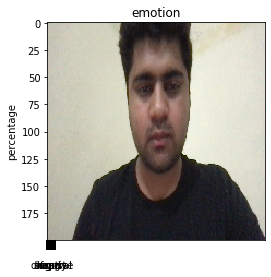

Expression Prediction: sad
Escape hit, closing...


In [20]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_1{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        getExpr(img_name)
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

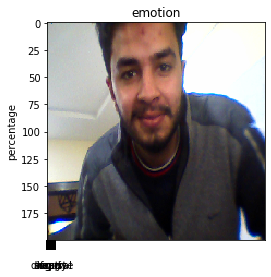

Expression Prediction: happy


In [18]:
from skimage import io
img = tf.keras.preprocessing.image.load_img("opencv_frame_0.png", color_mode = "grayscale", target_size=(48, 48))
show_img = tf.keras.preprocessing.image.load_img("opencv_frame_0.png", grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m = 0.000000000000000000001
a = custom[0]
for i in range(0,len(a)):
    if a[i] > m:
        m = a[i]
        ind = i

print('Expression Prediction:',objects[ind])

opencv_frame_10.png written!


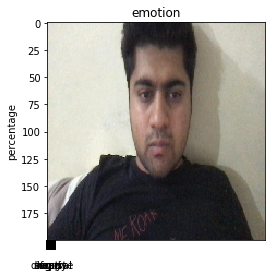

Expression Prediction: sad
opencv_frame_11.png written!


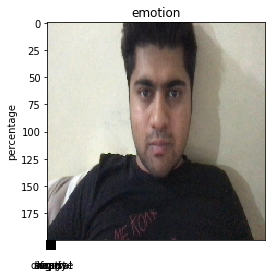

Expression Prediction: sad
opencv_frame_12.png written!


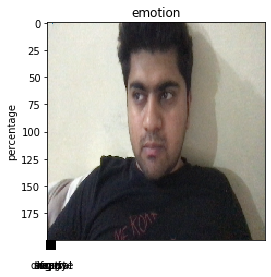

Expression Prediction: sad
opencv_frame_13.png written!


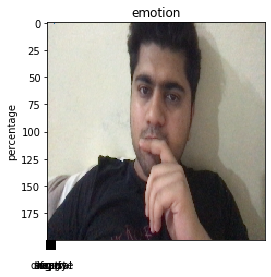

Expression Prediction: neutral
Escape hit, closing...


In [20]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_1{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        getExpr(img_name)
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_10.png written!


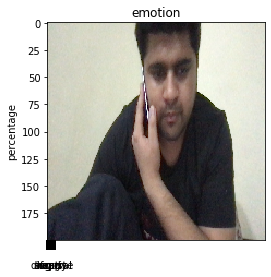

Expression Prediction: angry
opencv_frame_11.png written!


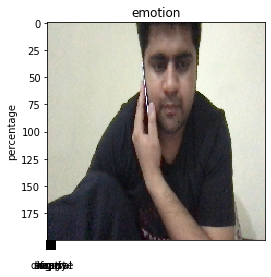

Expression Prediction: angry
opencv_frame_12.png written!


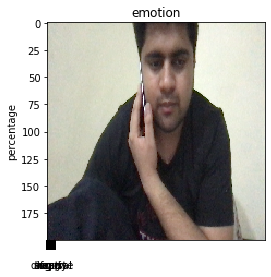

Expression Prediction: angry
opencv_frame_13.png written!


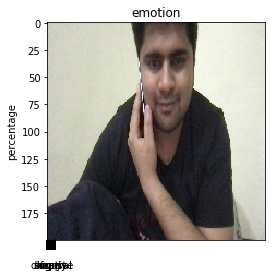

Expression Prediction: angry
opencv_frame_14.png written!


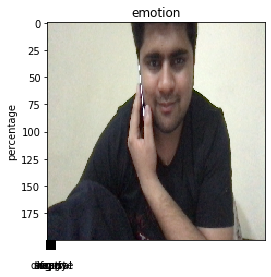

Expression Prediction: angry
opencv_frame_15.png written!


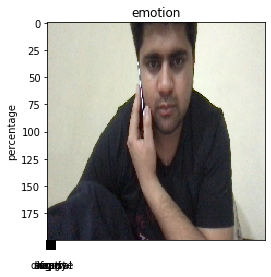

Expression Prediction: angry
opencv_frame_16.png written!


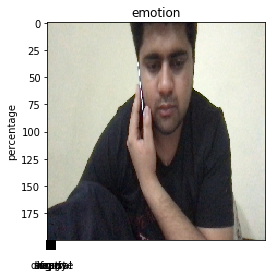

Expression Prediction: angry
opencv_frame_17.png written!


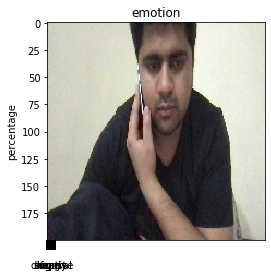

Expression Prediction: angry
opencv_frame_18.png written!


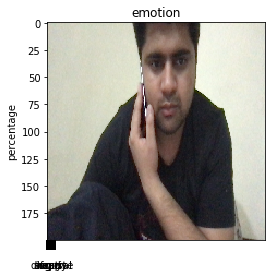

Expression Prediction: angry
opencv_frame_19.png written!


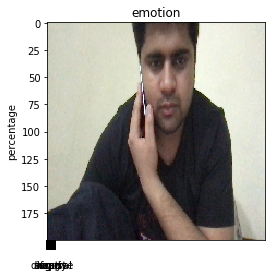

Expression Prediction: angry
opencv_frame_110.png written!


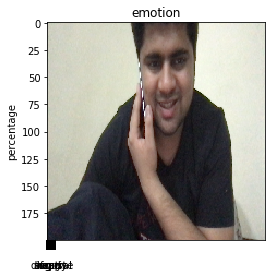

Expression Prediction: angry
opencv_frame_111.png written!


KeyboardInterrupt: 

In [27]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    img_name = "opencv_frame_1{}.png".format(img_counter)
    cv2.imwrite(img_name, frame)
    print("{} written!".format(img_name))
    getExpr(img_name)
    img_counter += 1

cam.release()

cv2.destroyAllWindows()